In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy   as np
import matplotlib.cm as cm
from scipy import stats
from ArcticTools import map
%matplotlib inline

In [4]:
nclist=['/ocean/xiaoxiny/research/result_jasper/data_exh005_bt/EXH005-bt_19912016.nc',
       # '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav/EXH005-btscav_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2/EXH005-btscav_v2_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2_cv/EXH005-btscav2_cv_19912015.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2_2xvel/EXH005-btscav2_2v_19912016.nc'
       ]

In [5]:
deep= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['deep'][:]
shallow= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['shalow'][:]
nav_lat= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lat'][:]
nav_lon= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lon'][:]
e3t= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e3t_0'][0,:]

In [6]:
Bathy=nc.Dataset('/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=Bathy.variables['Bathymetry'][400:,:]

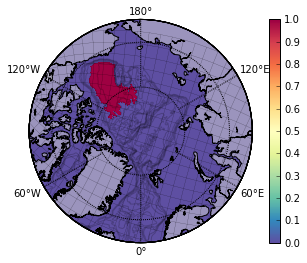

In [7]:
m,x_lon,y_lat = map.mapping(65)
m.pcolor(x_lon,y_lat,deep,cmap='Spectral_r');plt.colorbar()

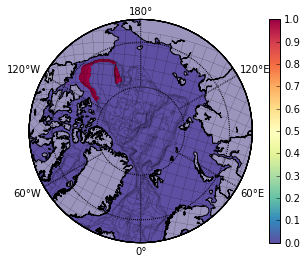

In [8]:
m,x_lon,y_lat = map.mapping(65)
shallow[nav_lat>78]=0
shallow[nav_lon<-160]=0
shallow[bathy< 500]=0
m.pcolor(x_lon,y_lat,shallow,cmap='Spectral_r');plt.colorbar()

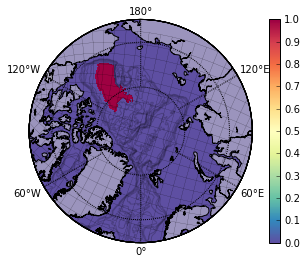

In [9]:
deep3 = np.copy(deep)
deep3[bathy<3500]=0
m,x_lon,y_lat = map.mapping(65)
m.pcolor(x_lon,y_lat,deep3,cmap='Spectral_r');plt.colorbar()
deep3[nav_lon<-150]=0;deep3[nav_lat<75]=0

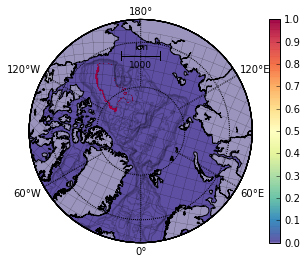

In [10]:
# finding the edge to deep3 (refer as d3 later) so that the edge advection can be calculated
d3edge = np.copy(deep)
d3edge[bathy<3500]=0
d3edge[bathy>3600]=0
m,x_lon,y_lat = map.mapping(65);m.drawmapscale(-180, 73, -180, 73, 1000 )
m.pcolor(x_lon,y_lat,d3edge,cmap='Spectral_r',alpha=0.8);plt.colorbar()

In [11]:
def load_data(ptrc,layer = 30, string = 'TR_8'):
    data = ptrc.variables[string][:,layer,...]
    return data
import glob
def load_vel(vel_comp,year,layer, deep_shawlow_file, ENG = 'EXH005'):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG.upper(),vel_comp,year))[0]) as velocity:
        data  = velocity.variables[vels[vel_comp]][0,layer,400:,:]
    data  = np.ma.masked_where(deep_shawlow_file[:] == 0,data)
    return data

from ArcticTools import Topostrophy_sepecific_layer as Ts
year = 2002;layer = 30
tempu = Ts.load_v('U',year,'EXH005','U')[layer,:,:]
tempv = Ts.load_v('V',year,'EXH005','V')[layer,:,:]
tempv.shape

(400, 544)

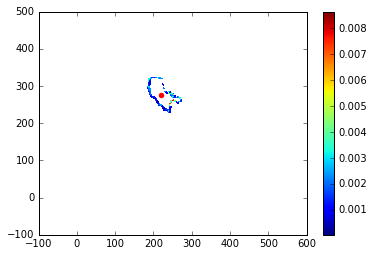

In [18]:
# estimate the magnitude of adv.
tot  = load_data(nc.Dataset(nclist[1]),layer = 30, string = 'TR_8')\
     + load_data(nc.Dataset(nclist[1]),layer = 30, string = 'TR_10')
year = 2009
u = (load_vel('U',np.int(year),layer = 30,deep_shawlow_file = d3edge, ENG = 'exh005')**2+\
    load_vel('V',np.int(year),layer = 30,deep_shawlow_file = d3edge, ENG = 'exh005')**2)**0.5
adv = u * tot[year-1991]/1000*1e3

plt.pcolor(adv);plt.colorbar()

plt.scatter(220,275,color='r')

In [16]:
'''Averaged magnitude of adv'''
adv[adv==0]=np.nan
np.nanmean(adv)

0.001689477

Compared to the tracer magnitude below, the effect from advection is one magnitude lower than S (see the figure at bottom). Won't expect too much difference with advection added..

In [42]:
def advtrc(x,y,u,v,trc,xc=220,yc=275,zone = d3edge):
    '''this version is an upgated version of adv_from_MB coded in lower cell'''
    '''assume this happened in a Cartesian coordinate and ignore the npstere projection'''
    # angle
    a = yc - y;b = xc - x;c = np.sqrt(a**2+b**2)
    cos = b/c; sin = a/c
    
    adv = (cos* u + sin*v)*trc
    adv[d3edge ==0] = np.nan
    return np.nanmean(adv)

In [34]:
x,y = np.meshgrid(np.linspace(1,tot.shape[-1],tot.shape[-1]),\
                  np.linspace(1,tot.shape[-2],tot.shape[-2]))

In [44]:
u = load_vel('U',np.int(year),layer = 30,deep_shawlow_file = d3edge, ENG = 'exh005')
v = load_vel('V',np.int(year),layer = 30,deep_shawlow_file = d3edge, ENG = 'exh005')
adv = advtrc(x,y,u,v,trc=tot[year-1991,...],xc=220,yc=275,zone = d3edge);
adv

-0.00031547379353338671

In [18]:
colors = cm.bone(np.linspace(0, 0.8, 4))

In [17]:
def init():
    array ={'a':[],'b':[]}
    return array

In [47]:
def load_depth(ptrc):
    data = ptrc.variables['deptht'][:]
    return data

dep = load_depth(ptrc=nc.Dataset(nclist[2]))
dep[31]-dep[29]

160.87592

In [20]:
a= np.array([0.,1.,2.,3.,4.,5.])
a[a<2]=np.nan
a,np.nanmean(a)

(array([ nan,  nan,   2.,   3.,   4.,   5.]), 3.5)

In [49]:
def dsfilter(data,shallow,deep):
    TR_8b = np.copy(data)            ;TR_8i = np.copy(data)
    TR_8b[shallow == 0] = np.nan     ;TR_8i[deep == 0] = np.nan
    xb = np.nanmean(TR_8b)
    xi = np.nanmean(TR_8i)
    return xb,xi

# layer 30

In [50]:
colors = cm.Spectral(np.linspace(0, 1, 6))

In [51]:
def boundarysource(xp,dz,sink):
    '''xp should contain three elements: xp(z-1),xp(z),xp(z+1)'''
    '''sink should contain three elements: sinking (z-1), z, (z+1)'''
    Q = 0.0267
    sb = Q + ((sink[0]*xp[0]) - (sink[2]* xp[2]))/dz
    return sb

def adv_from_MB(tot,year):
    # estimate the magnitude of adv.
    u = (load_vel('U',np.int(year),layer = 30,deep_shawlow_file = d3edge, ENG = 'exh005')**2+\
        load_vel('V',np.int(year),layer = 30,deep_shawlow_file = d3edge, ENG = 'exh005')**2)**0.5
    adv = u * tot[year-1991]/1000*1e3
    adv[adv==0]=np.nan
    return np.nanmean(adv)

def tmix(xb,xi,xbt,dt,xp,dz,sink,box,adv):
    '''
       
       xb_t: should contain two elements: x(t-1), x(t)
       dt: time step (default is 1 year)
       
       spatials are all in centre difference/ temporaries are all in forward difference'''
    
    s  = boundarysource(xp,dz,sink)
    if box == 'boundary':
        dtrc_dt = (xb - xbt)    /dt
    if box == 'internal':
        xit = xbt
        dtrc_dt = (xi - xit)    /dt
    
    tmix    = (xi-xb)/(dtrc_dt - s - adv) 
    
    return tmix,s,dtrc_dt

In [58]:
def Tmix(layer,box,shallow,deep):
    print('>> working on :%s m'%dep[layer]);tarray=[]
    TR_8  = load_data(nc.Dataset(nclist[1]),layer = layer, string = 'TR_8')\
          + load_data(nc.Dataset(nclist[1]),layer = layer, string = 'TR_10')
    TR_10_29 = load_data(nc.Dataset(nclist[1]),layer = layer-1, string = 'TR_10')
    TR_10_30 = load_data(nc.Dataset(nclist[1]),layer = layer, string = 'TR_10')
    TR_10_31 = load_data(nc.Dataset(nclist[1]),layer = layer+1, string = 'TR_10')

    TR_12_29 = load_data(nc.Dataset(nclist[1]),layer = layer-1, string = 'TR_12')
    TR_12_30 = load_data(nc.Dataset(nclist[1]),layer = layer, string = 'TR_12')
    TR_12_31 = load_data(nc.Dataset(nclist[1]),layer = layer+1, string = 'TR_12')
    
    for data in [TR_8,TR_10_29,TR_10_30,TR_10_31,TR_12_29,TR_12_30,TR_12_31]:
        data[data<=0] = np.nan

    f,ax=plt.subplots(4,figsize = (8,6),sharex=True);
    for t in range (2002,2015):
        '''dtrc/dt'''
        xb,xi = dsfilter(TR_8[t-1991,:,:],shallow, deep)
        xbt,xit = dsfilter(TR_8[t-1991-1,:,:],shallow, deep)

        dt = np.array([1]) # unit: yr
        '''s'''
        dz = e3t[layer]
        
        xpbc = [];xpin=[]
        for data in [TR_10_29[t-1991,:,:],TR_10_30[t-1991,:,:],TR_10_31[t-1991,:,:]]:
            bc_xp,in_xp = dsfilter(data,shallow, deep)
            xpbc.append(bc_xp)
            xpin.append(in_xp)
        xpbc = np.array(xpbc)
        xpin = np.array(xpin)
        
        icebc = [];icein = []
        for data in [TR_12_29[t-1991,:,:],TR_12_30[t-1991,:,:],TR_12_31[t-1991,:,:]]:
            ice_bc,ice_in = dsfilter(data,shallow, deep)
            icebc.append(ice_bc)
            icein.append(ice_in)
        '''adv'''
        #adv = adv_from_MB(TR_8[t-1991,:,:],t)
        #print (adv)
        
        u = load_vel('U',np.int(t),layer = layer,deep_shawlow_file = d3edge, ENG = 'exh005')
        v = load_vel('V',np.int(t),layer = layer,deep_shawlow_file = d3edge, ENG = 'exh005')
        adv = advtrc(x,y,u,v,trc=tot[t-1991,...],xc=220,yc=275,zone = d3edge);
        
        '''T mix'''
        if box == 'boundary':
            sink=-986.96*np.array(icebc)+1456.45
            mixing_ts,s,dtrc_dt = tmix(xb,xi,xbt,dt,xpbc,dz,sink,box,adv)
        if box == 'internal':
            sink=-986.96*np.array(icein)+1456.45
            mixing_ts,s,dtrc_dt = tmix(xb,xi,xit,dt,xpin,dz,sink,box,adv)
        
        tarray.append(mixing_ts)
        [myax.scatter(t,data,c=c) for myax,data,c in zip(ax,[mixing_ts,s,dtrc_dt-s,xi-xb],colors)]

    #ax[0].set_ylim(0,10)
    [myax.plot([2002,2016],[0,0],'k') for myax in ax[:] ]
    [myax.set_xlim([2002,2015]) for myax in ax ]
    [myax.set_ylim([-0.1,0.2]) for myax in ax[1:] ]
    [myax.set_title(label) for myax,label in zip(ax,['mixing_ts','s','dtrc_dt -s ','xi-xb']) ]
    return tarray

>> working on :453.938 m


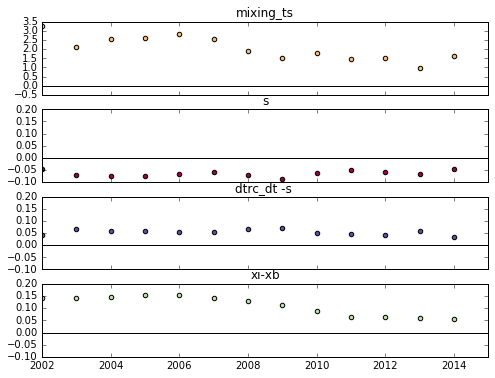

In [59]:
# with adv
Tbc=Tmix(30,box='boundary',shallow=shallow,deep=deep3)

>> working on :453.938 m


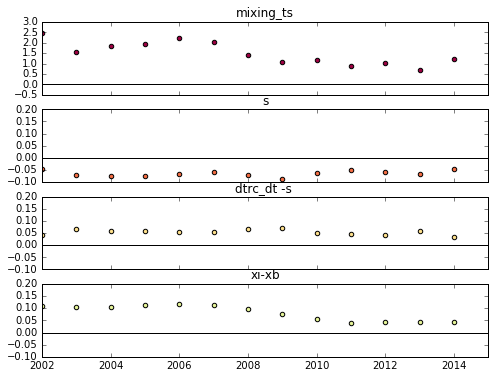

In [54]:
# without adv (from stp3)
Tbc=Tmix(30,box='boundary',shallow=shallow,deep=deep3)

In [104]:
def Tmix4_layers(Layer,box,shallow,deep):
    k = 0
    tmixing ={'layer1':[],'layer2':[],'layer3':[],'layer4':[],'layer5':[],'layer6':[]}
    for i,tarray in zip (range (len(Layer)),[tmixing['layer1'],tmixing['layer2'],\
                                             tmixing['layer3'],tmixing['layer4'],\
                                             tmixing['layer5'],tmixing['layer6']],):
        
        layer = Layer[i];
        #print('>> working on :%s m'%dep[layer])
        '''prepare data'''
        TR_8  = load_data(nc.Dataset(nclist[1]),layer = layer, string = 'TR_8')#\
              #+ load_data(nc.Dataset(nclist[1]),layer = layer, string = 'TR_10')
        TR_10_29 = load_data(nc.Dataset(nclist[1]),layer = layer-1, string = 'TR_10')
        TR_10_30 = load_data(nc.Dataset(nclist[1]),layer = layer, string = 'TR_10')
        TR_10_31 = load_data(nc.Dataset(nclist[1]),layer = layer+1, string = 'TR_10')

        TR_12_29 = load_data(nc.Dataset(nclist[1]),layer = layer-1, string = 'TR_12')
        TR_12_30 = load_data(nc.Dataset(nclist[1]),layer = layer, string = 'TR_12')
        TR_12_31 = load_data(nc.Dataset(nclist[1]),layer = layer+1, string = 'TR_12')

        for data in [TR_8,TR_10_29,TR_10_30,TR_10_31,TR_12_29,TR_12_30,TR_12_31]:
            data[data<=0] = np.nan

        for t in range (2002,2015):
            '''dtrc/dt'''
            xb,xi = dsfilter(TR_8[t-1991,:,:],shallow, deep)
            xbt,xit = dsfilter(TR_8[t-1991-1,:,:],shallow, deep)

            dt = np.array([1]) # unit: yr
            '''s'''
            dz = e3t[layer]

            xpbc = [];xpin=[]
            for data in [TR_10_29[t-1991,:,:],TR_10_30[t-1991,:,:],TR_10_31[t-1991,:,:]]:
                bc_xp,in_xp = dsfilter(data,shallow, deep)
                xpbc.append(bc_xp)
                xpin.append(in_xp)
            xpbc = np.array(xpbc)
            xpin = np.array(xpin)

            icebc = [];icein = []
            for data in [TR_12_29[t-1991,:,:],TR_12_30[t-1991,:,:],TR_12_31[t-1991,:,:]]:
                ice_bc,ice_in = dsfilter(data,shallow, deep)
                icebc.append(ice_bc)
                icein.append(ice_in)
            '''adv'''
            #adv = adv_from_MB(TR_8[t-1991,:,:],t)
            
            u = load_vel('U',np.int(t),layer = layer,deep_shawlow_file = d3edge, ENG = 'exh005')
            v = load_vel('V',np.int(t),layer = layer,deep_shawlow_file = d3edge, ENG = 'exh005')
            adv = advtrc(x,y,u,v,trc=tot[t-1991,...],xc=220,yc=275,zone = d3edge);
            #if t ==2002: print ('check adv magnituede: %s'%adv);

            '''T mix'''
            if box == 'boundary':
                sink=-986.96*np.array(icebc)+1456.45
                mixing_ts,s,dtrc_dt = tmix(xb,xi,xbt,dt,xpbc,dz,sink,box,-adv)
            if box == 'internal':
                sink=-986.96*np.array(icein)+1456.45
                mixing_ts,s,dtrc_dt = tmix(xb,xi,xit,dt,xpin,dz,sink,box,adv)
            tarray.append(mixing_ts)
        
    return tmixing

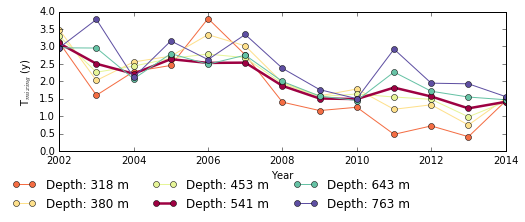

In [105]:
tmixing = Tmix4_layers([28,29,30,31,32,33],box='boundary',shallow=shallow,deep=deep3)
colors = cm.Spectral(np.linspace(0, 1, 6))
colors = np.array([colors[1],colors[2],colors[3],colors[0],colors[4],colors[5]])    
f = plt.figure(figsize = (8,2.5))
for tarray,c,layer in zip ([tmixing['layer1'],tmixing['layer2'],tmixing['layer3'],\
                            tmixing['layer4'],tmixing['layer5'],tmixing['layer6']],
                           colors,[dep[28],dep[29],dep[30],dep[31],dep[32],dep[33]]):
    if layer == dep[31]: lw = 2.5; 
    else: lw = 1
    plt.plot(np.linspace(2002,2014,13),tarray,'-o',c=c,lw=lw,label='Depth: %s m'%np.int(layer))
    plt.xlabel('Year');plt.ylabel('T$_{mixing}$ (y)')
    plt.legend(loc=3,bbox_to_anchor=(-0.13,-0.5),ncol=3, frameon=False)

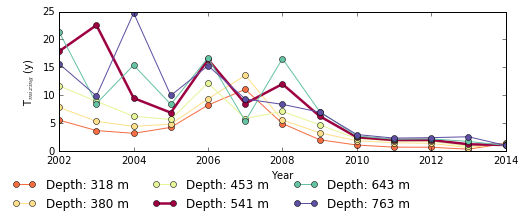

In [102]:
tmixing = Tmix4_layers([28,29,30,31,32,33],box='internal',shallow=shallow,deep=deep3)
colors = cm.Spectral(np.linspace(0, 1, 6))
colors = np.array([colors[1],colors[2],colors[3],colors[0],colors[4],colors[5]])    
f = plt.figure(figsize = (8,2.5))
for tarray,c,layer in zip ([tmixing['layer1'],tmixing['layer2'],tmixing['layer3'],\
                            tmixing['layer4'],tmixing['layer5'],tmixing['layer6']],
                           colors,[dep[28],dep[29],dep[30],dep[31],dep[32],dep[33]]):
    if layer == dep[31]: lw = 2.5; 
    else: lw = 1
    plt.plot(np.linspace(2002,2014,13),tarray,'-o',c=c,lw=lw,label='Depth: %s m'%np.int(layer))
    plt.xlabel('Year');plt.ylabel('T$_{mixing}$ (y)')
    plt.legend(loc=3,bbox_to_anchor=(-0.13,-0.5),ncol=3, frameon=False)

With advection added, magnitude of mixing time scale has varied by ~0.5 years. However, such increase is not obvious compared to the time scale calculated in stp3...

There is an interesting phenonemon though.. T increses while depth increases. :)

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
